In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 30 07:47:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

--2022-01-30 07:47:11--  https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5169 (5.0K) [text/plain]
Saving to: ‘losses.py’

losses.py           100%[===================>]   5.05K  --.-KB/s    in 0s      

2022-01-30 07:47:11 (93.6 MB/s) - ‘losses.py’ saved [5169/5169]



In [ ]:
!pip install tensorflow_addons
import losses

     |████████████████████████████████| 1.1 MB 6.9 MB/s 


170508288/170498071 [==============================] - 3s 0us/step


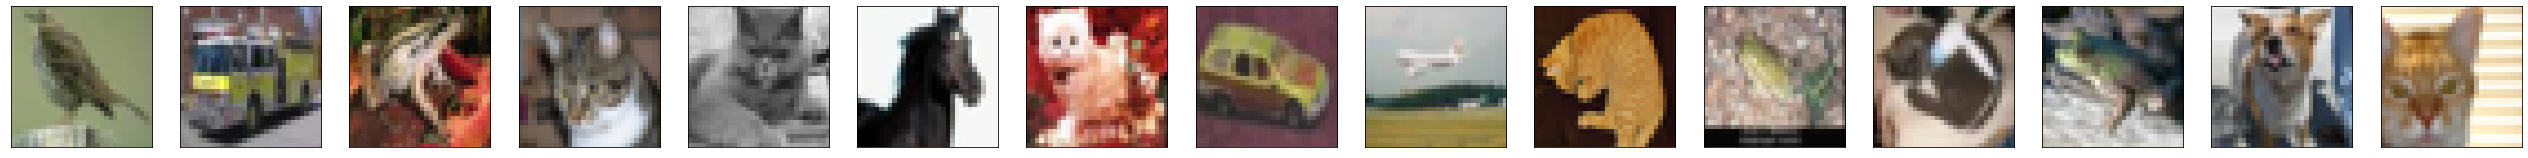

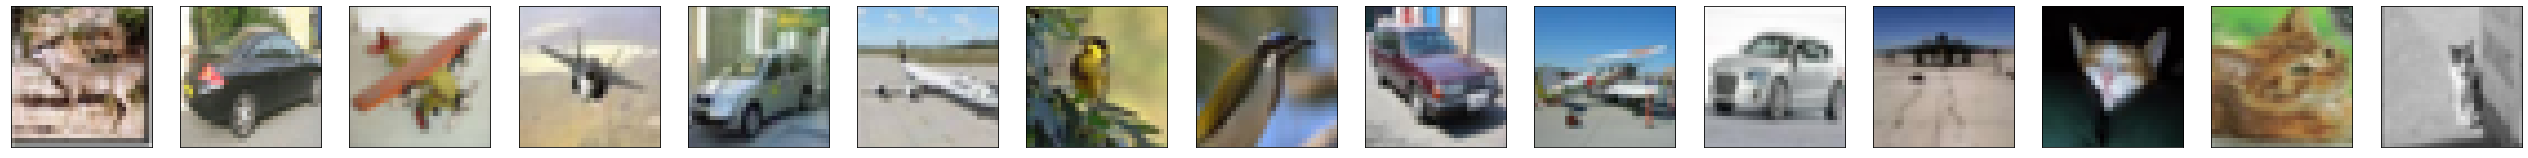

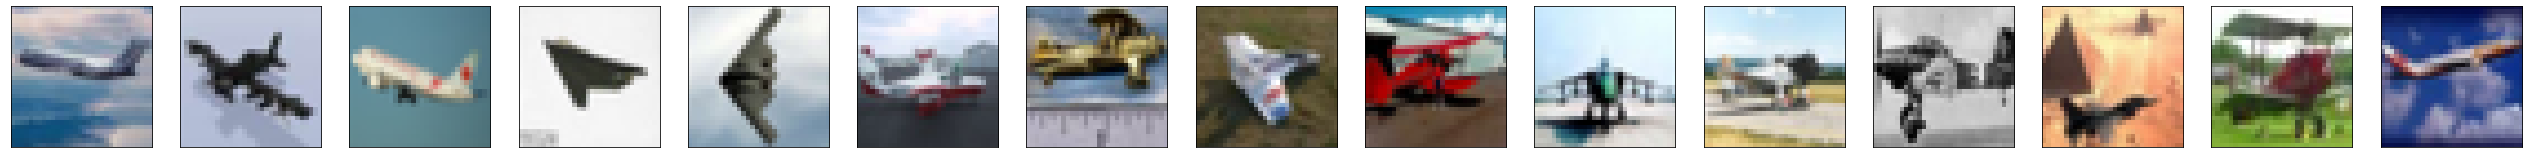

In [ ]:
import tensorflow as tf
import numpy as np
import tqdm
import random
import matplotlib.pyplot as plt

import FSHA
import architectures
import datasets
from datasets import *

#load cifar10 dataset
cpriv, cpub = load_cifar()
cpriv5, cpub5 = load_cifar_5()

n = 15
c_priv = datasets.getImagesDS(cpriv, n)
c_pub5 = datasets.getImagesDS(cpub5, n)

datasets.plot(c_priv)
datasets.plot(c_pub5)

cpub10 = load_cifar_test_10()
n = 15
c_test0 = datasets.getImagesDS(cpub10[0], n)
datasets.plot(c_test0)

# training hparams
batch_size = 64
id_setup = 4
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'w' : 3,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
}
log_frequency = 100

def get_cos_sim(v1, v2):
  num = float(np.dot(v1,v2))
  denom = np.linalg.norm(v1) * np.linalg.norm(v2)
  return 0.5 + 0.5 * (num / denom) if denom != 0 else 0

def plot_gradient(fsha_model, sl_model, dataset, itr):
  dif_category_fsha = []
  con_image_fsha = []
  same_category_fsha = []
  dif_category_sl = []
  con_image_sl = []
  same_category_sl = []

  for k in range(10):
    c_set = list(dataset)
    c1 = []
    c2 = []
    c3 = []
    c1_x = []
    c2_x = []
    c3_x = []
    c4_x = []
    c1_y = []
    c2_y = []
    c3_y = []
    c4_y = []
    for j in range(2000):
      if len(c1) < 64:
        if c_set[j][1].numpy() == np.array(k):
          c1_x.append(c_set[j][0])
          c1_y.append(c_set[j][1])
          c1.append(j)
          e = c_set[j][0].numpy()
          e = -e
          c4 = tf.convert_to_tensor(e, dtype=tf.float32)
          c4_x.append(c4)
          c4_y.append((k+2)%10)
      elif len(c3) < 64:
        if c_set[j][1].numpy() == np.array(k):
          c3_x.append(c_set[j][0])
          c3_y.append(c_set[j][1])
          c3.append(j)
      if len(c2) < 64:
        if c_set[j][1].numpy() == np.array((k+1)%10):
          c2_x.append(c_set[j][0])
          c2_y.append(c_set[j][1])
          c2.append(j)
    

    c1_x = tf.stack(c1_x, axis = 0)
    c2_x = tf.stack(c2_x, axis = 0)
    c3_x = tf.stack(c3_x, axis = 0)
    c4_x = tf.stack(c4_x, axis = 0)

    gp1 = fsha_model.get_gradient(c1_x, c1_y).numpy()
    gp2 = fsha_model.get_gradient(c2_x, c2_y).numpy()
    gp3 = fsha_model.get_gradient(c3_x, c3_y).numpy()
    gp4 = fsha_model.get_gradient(c4_x, c4_y).numpy()
    gf1 = sl_model.get_gradient(c1_x, c1_y).numpy()
    gf2 = sl_model.get_gradient(c2_x, c2_y).numpy()
    gf3 = sl_model.get_gradient(c3_x, c3_y).numpy()
    gf4 = sl_model.get_gradient(c4_x, c4_y).numpy()

    dif_category_4k_fsha = []
    con_image_4k_fsha = []
    same_category_4k_fsha = []
    dif_category_4k_sl = []
    con_image_4k_sl = []
    same_category_4k_sl = []
    for i in range(64):
      p1 = gp1[i].reshape(4096,)
      p2 = gp2[i].reshape(4096,)
      p3 = gp3[i].reshape(4096,)
      p4 = gp4[i].reshape(4096,)
      f1 = gf1[i].reshape(4096,)
      f2 = gf2[i].reshape(4096,)
      f3 = gf3[i].reshape(4096,)
      f4 = gf4[i].reshape(4096,)
      dif_category_4k_fsha.append(get_cos_sim(p1,p2))
      dif_category_4k_sl.append(get_cos_sim(f1,f2))
      con_image_4k_fsha.append(get_cos_sim(p1,p4))
      con_image_4k_sl.append(get_cos_sim(f1,f4))
      same_category_4k_fsha.append(get_cos_sim(p1,p3))
      same_category_4k_sl.append(get_cos_sim(f1,f3))
      dif_category_fsha.append(get_cos_sim(p1,p2))
      dif_category_sl.append(get_cos_sim(f1,f2))
      con_image_fsha.append(get_cos_sim(p1,p4))
      con_image_sl.append(get_cos_sim(f1,f4))
      same_category_fsha.append(get_cos_sim(p1,p3))
      same_category_sl.append(get_cos_sim(f1,f3))

    dif_category_4k_fsha = np.array(dif_category_4k_fsha)
    con_image_4k_fsha = np.array(con_image_4k_fsha)
    same_category_4k_fsha = np.array(same_category_4k_fsha)
    dif_category_4k_sl = np.array(dif_category_4k_sl)
    con_image_4k_sl = np.array(con_image_4k_sl)
    same_category_4k_sl = np.array(same_category_4k_sl)
    print("category: ", k)
    print(np.mean(dif_category_4k_fsha), np.mean(dif_category_4k_sl))
    print(np.mean(con_image_4k_fsha), np.mean(con_image_4k_sl))
    print(np.mean(same_category_4k_fsha), np.mean(same_category_4k_sl))
    fsha_4k = [np.mean(dif_category_4k_fsha), np.mean(con_image_4k_fsha), np.mean(same_category_4k_fsha)]
    sl_4k = [np.mean(dif_category_4k_sl), np.mean(con_image_4k_sl), np.mean(same_category_4k_sl)]
    fsha_std_4k = [np.std(dif_category_4k_fsha), np.std(con_image_4k_fsha), np.std(same_category_4k_fsha)]
    sl_std_4k = [np.std(dif_category_4k_sl), np.std(con_image_4k_sl), np.std(same_category_4k_sl)]
    x = np.arange(3)
    error_attri={"elinewidth":2,"ecolor":"black","capsize":6}
    bar_width=0.4
    tick_label=['dif category','con_sample','same category']
    plt.bar(x,fsha_4k,bar_width, color="#87cee3",align="center",yerr=fsha_std_4k,error_kw=error_attri,label='abnormal',alpha=1)
    plt.bar(x+bar_width,sl_4k,bar_width,color="#cd5c5c",yerr=sl_std_4k,error_kw=error_attri,label='normal',alpha=1)
    plt.xlabel('')
    plt.ylabel("cosine similarity")
    plt.xticks(x+bar_width/2, tick_label)
    plt.title("%d iteration" % (itr))
    plt.grid(axis="y",ls="-",color="purple",alpha=0.7)
    plt.legend()
    plt.show()
  
  print("==================================================")
  print("average gradient: ")
  dif_category_4k_fsha = np.array(dif_category_fsha)
  con_image_4k_fsha = np.array(con_image_fsha)
  same_category_4k_fsha = np.array(same_category_fsha)
  dif_category_4k_sl = np.array(dif_category_sl)
  con_image_4k_sl = np.array(con_image_sl)
  same_category_4k_sl = np.array(same_category_sl)
  print("category: ", k)
  print(np.mean(dif_category_4k_fsha), np.mean(dif_category_4k_sl))
  print(np.mean(con_image_4k_fsha), np.mean(con_image_4k_sl))
  print(np.mean(same_category_4k_fsha), np.mean(same_category_4k_sl))
  fsha_4k = [np.mean(dif_category_4k_fsha), np.mean(con_image_4k_fsha), np.mean(same_category_4k_fsha)]
  sl_4k = [np.mean(dif_category_4k_sl), np.mean(con_image_4k_sl), np.mean(same_category_4k_sl)]
  fsha_std_4k = [np.std(dif_category_4k_fsha), np.std(con_image_4k_fsha), np.std(same_category_4k_fsha)]
  sl_std_4k = [np.std(dif_category_4k_sl), np.std(con_image_4k_sl), np.std(same_category_4k_sl)]
  x = np.arange(3)
  error_attri={"elinewidth":2,"ecolor":"black","capsize":6}
  bar_width=0.4
  tick_label=['dif category','con_sample','same category']
  plt.bar(x,fsha_4k,bar_width, color="#87cee3",align="center",yerr=fsha_std_4k,error_kw=error_attri,label='abnormal',alpha=1)
  plt.bar(x+bar_width,sl_4k,bar_width,color="#cd5c5c",yerr=sl_std_4k,error_kw=error_attri,label='normal',alpha=1)
  plt.xlabel('')
  plt.ylabel("cosine similarity")
  plt.xticks(x+bar_width/2, tick_label)
  plt.title("%d iteration" % (itr))
  plt.grid(axis="y",ls="-",color="purple",alpha=0.7)
  plt.legend()
  plt.show()


In [ ]:
# preparing for test set
c_set = list(cpriv)
c1x = []
c1y = []
c2x = []
c2y = []
c3x = []
c3y = []
for k in range(10):
  c1 = []
  c2 = []
  c3 = []
  c1_x = []
  c2_x = []
  c3_x = []
  c1_y = []
  c2_y = []
  c3_y = []
  for j in range(2000):
    if len(c1) < 64:
      if c_set[j][1].numpy() == np.array(k):
        c1_x.append(c_set[j][0])
        c1_y.append(c_set[j][1])
        c1.append(j)
    elif len(c3) < 64:
      if c_set[j][1].numpy() == np.array(k):
        c3_x.append(c_set[j][0])
        c3_y.append(c_set[j][1])
        c3.append(j)
    if len(c2) < 64:
      if c_set[j][1].numpy() == np.array((k+1)%10):
        c2_x.append(c_set[j][0])
        c2_y.append(c_set[j][1])
        c2.append(j)
  c1_x = tf.stack(c1_x, axis = 0)
  c2_x = tf.stack(c2_x, axis = 0)
  c3_x = tf.stack(c3_x, axis = 0)
  c1x.append(c1_x)
  c1y.append(c1_y)
  c2x.append(c2_x)
  c2y.append(c2_y)
  c3x.append(c3_x)
  c3y.append(c3_y)

In [ ]:
import tensorflow as tf
import numpy as np
import tqdm
import datasets, architectures

def distance_data_loss(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

def distance_data(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

class FSHA_ori:
    
    def loadBiasNetwork(self, make_decoder, z_shape, channels):
        return make_decoder(z_shape, channels=channels)
        
    def __init__(self, xpriv, xpub, id_setup, batch_size, hparams):
            input_shape = xpriv.element_spec[0].shape
            
            self.hparams = hparams

            # setup dataset
            self.client_dataset = xpriv.batch(batch_size, drop_remainder=True).repeat(-1)
            self.attacker_dataset = xpub.batch(batch_size, drop_remainder=True).repeat(-1)
            self.batch_size = batch_size

            ## setup models
            make_f, make_tilde_f, make_decoder, make_D = architectures.SETUPS[id_setup]

            self.f = make_f(input_shape)
            self.tilde_f = make_tilde_f(input_shape)

            assert self.f.output.shape.as_list()[1:] == self.tilde_f.output.shape.as_list()[1:]
            z_shape = self.tilde_f.output.shape.as_list()[1:]

            self.D = make_D(z_shape)
            self.decoder = self.loadBiasNetwork(make_decoder, z_shape, channels=input_shape[-1])

            # setup optimizers
            self.optimizer0 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_f'])
            self.optimizer1 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_tilde'])
            self.optimizer2 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_D'])



    @staticmethod
    def addNoise(x, alpha):
        return x + tf.random.normal(x.shape) * alpha

    @tf.function
    def train_step(self, x_private, x_public, label_private, label_public):

        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            # map to data space (for evaluation and style loss)
            rec_x_private = self.decoder(z_private, training=True)
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=True)
            if self.hparams['WGAN']:
                print("Use WGAN loss")
                f_loss = tf.reduce_mean(adv_private_logits)
            else:
                f_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True))
            ##

            z_public = self.tilde_f(x_public, training=True)

            # invertibility loss
            rec_x_public = self.decoder(z_public, training=True)
            public_rec_loss = distance_data_loss(x_public, rec_x_public)
            tilde_f_loss = public_rec_loss


            # discriminator on attacker's feature-space
            adv_public_logits = self.D(z_public, training=True)
            if self.hparams['WGAN']:
                loss_discr_true = tf.reduce_mean( adv_public_logits )
                loss_discr_fake = -tf.reduce_mean( adv_private_logits)
                # discriminator's loss
                D_loss = loss_discr_true + loss_discr_fake
            else:
                loss_discr_true = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_public_logits), adv_public_logits, from_logits=True))
                loss_discr_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(adv_private_logits), adv_private_logits, from_logits=True))
                # discriminator's loss
                D_loss = (loss_discr_true + loss_discr_fake) / 2

            if 'gradient_penalty' in self.hparams:
                print("Use GP")
                w = float(self.hparams['gradient_penalty'])
                D_gradient_penalty = self.gradient_penalty(z_private, z_public)
                D_loss += D_gradient_penalty * w

            ##################################################################
            ## attack validation #####################
            loss_c_verification = distance_data(x_private, rec_x_private)
            ############################################
            ##################################################################


        # train client's network 
        var = self.f.trainable_variables
        gradients = tape.gradient(f_loss, var)
        self.optimizer0.apply_gradients(zip(gradients, var))

        # train attacker's autoencoder on public data
        var = self.tilde_f.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(tilde_f_loss, var)
        self.optimizer1.apply_gradients(zip(gradients, var))

        # train discriminator
        var = self.D.trainable_variables
        gradients = tape.gradient(D_loss, var)
        self.optimizer2.apply_gradients(zip(gradients, var))


        return f_loss, tilde_f_loss, D_loss, loss_c_verification


    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.D(x_hat, training=True)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer
    
    
    @tf.function
    def score(self, x_private, label_private):
        z_private = self.f(x_private, training=False)
        tilde_x_private = self.decoder(z_private, training=False)
        
        err = tf.reduce_mean( distance_data(x_private, tilde_x_private) )
        
        return err
    
    def scoreAttack(self, dataset):
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        scorelog = 0
        i = 0
        for x_private, label_private in tqdm.tqdm(dataset):
            scorelog += self.score(x_private, label_private).numpy()
            i += 1
             
        return scorelog / i

    def attack(self, x_private):
        # smashed data sent from the client:
        z_private = self.f(x_private, training=False)
        # recover private data from smashed data
        tilde_x_private = self.decoder(z_private, training=False)

        z_private_control = self.tilde_f(x_private, training=False)
        control = self.decoder(z_private_control, training=False)
        return tilde_x_private.numpy(), control.numpy()
    
    def get_gradient(self, x_private, label_private):
        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            # map to data space (for evaluation and style loss)
            rec_x_private = self.decoder(z_private, training=True)
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=True)
            if self.hparams['WGAN']:
                # print("Use WGAN loss")
                f_loss = tf.reduce_mean(adv_private_logits)
            else:
                f_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True))
            ##

        var = z_private
        gradients = tape.gradient(f_loss, var)
        return gradients

    def __call__(self, iterations, log_frequency=500, verbose=False, progress_bar=True):

        n = int(iterations / log_frequency)
        LOG = np.zeros((n, 4))
        dif_category = []
        same_category = []
        for i in range(10):
          dif_category.append([])
          same_category.append([])
        dif_category_mean = []
        dif_variance = []
        same_variance = []
        same_category_mean = []
        iterator = zip(self.client_dataset.take(iterations), self.attacker_dataset.take(iterations))
        if progress_bar:
            iterator = tqdm.tqdm(iterator , total=iterations)

        i, m = 0, 0
        print("RUNNING...")
        for (x_private, label_private), (x_public, label_public) in iterator:
            log = self.train_step(x_private, x_public, label_private, label_public)

            if i == 0:
                VAL = log[3]                           
            else:
                VAL += log[3] / log_frequency

            if  i % log_frequency == 0:
                dif_category_mean_ = []
                same_category_mean_ = []
                for k in range(10):
                  gp1 = self.get_gradient(c1x[k], c1y[k]).numpy()
                  gp2 = self.get_gradient(c2x[k], c2y[k]).numpy()
                  gp3 = self.get_gradient(c3x[k], c3y[k]).numpy()

                  dif_category_fsha = []
                  same_category_fsha = []
                  
                  for l in range(64):
                    p1 = gp1[l].reshape(4096,)
                    p2 = gp2[l].reshape(4096,)
                    p3 = gp3[l].reshape(4096,)
                    dif_category_fsha.append(get_cos_sim(p1,p2))
                    same_category_fsha.append(get_cos_sim(p1,p3))
                    dif_category_mean_.append(get_cos_sim(p1,p2))
                    same_category_mean_.append(get_cos_sim(p1,p3))
                  dif_category_fsha = np.array(dif_category_fsha)
                  same_category_fsha = np.array(same_category_fsha)
                  dif_category[k].append(np.mean(dif_category_fsha))
                  same_category[k].append(np.mean(dif_category_fsha))
                dif_category_mean_ = np.array(dif_category_mean_)
                same_category_mean_ = np.array(same_category_mean_)
                dif_category_mean.append(np.mean(dif_category_mean_))
                same_category_mean.append(np.mean(same_category_mean_))
                dif_variance.append(np.std(dif_category_mean_))
                same_variance.append(np.std(same_category_mean_))

                  
                LOG[m] = log

                if verbose:
                    print("log--%02d%%-%07d] validation: %0.4f" % ( int(i/iterations*100) ,i, VAL) )

                VAL = 0
                m += 1


            i += 1
        return LOG, dif_category, same_category, dif_category_mean, same_category_mean, dif_variance, same_variance

In [ ]:
# Good server
import datasets, arch

def distance_data_loss(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

def distance_data(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

class SL_new:

    def __init__(self, xpriv, xpub, id_setup, batch_size, hparams):
            input_shape = xpriv.element_spec[0].shape
            
            self.hparams = hparams

            # setup dataset
            self.client_dataset = xpriv.batch(batch_size, drop_remainder=True).repeat(-1)
            self.attacker_dataset = xpub.batch(batch_size, drop_remainder=True).repeat(-1)
            self.batch_size = batch_size

            ## setup models
            make_f, make_s = arch.SETUPS[id_setup]

            self.f = make_f(input_shape)
            s_shape = self.f.output.shape.as_list()[1:]
            self.s = make_s(s_shape)

            # setup optimizers
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparams['lr_f'])



    @staticmethod
    def addNoise(x, alpha):
        return x + tf.random.normal(x.shape) * alpha

    def train_step(self, x_private, x_public, label_private, label_public):

        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.s(z_private, training=True)
            f_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##

        # train network 
        var = self.f.trainable_variables + self.s.trainable_variables
        gradients = tape.gradient(f_loss, var)
        self.optimizer.apply_gradients(zip(gradients, var))

        return tf.reduce_mean(f_loss)


    def get_gradient(self, x_private, label_private):
        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.s(z_private, training=True)
            f_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##

        var = z_private
        gradients = tape.gradient(f_loss, var)
        return gradients

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.D(x_hat, training=True)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer
    
    def __call__(self, iterations, log_frequency=500, verbose=False, progress_bar=True):

        n = int(iterations / log_frequency)
        LOG = np.zeros((n, 4))
        dif_category = []
        same_category = []
        for i in range(10):
          dif_category.append([])
          same_category.append([])
        dif_category_mean = []
        same_category_mean = []
        dif_variance = []
        same_variance = []
        gradients = []
        iterator = zip(self.client_dataset.take(iterations), self.attacker_dataset.take(iterations))
        if progress_bar:
            iterator = tqdm.tqdm(iterator , total=iterations)
        dif_category_mean_ = []
        same_category_mean_ = []
        for k in range(10):
          gp1 = self.get_gradient(c1x[k], c1y[k]).numpy()
          gp2 = self.get_gradient(c2x[k], c2y[k]).numpy()
          gp3 = self.get_gradient(c3x[k], c3y[k]).numpy()

          dif_category_fsha = []
          same_category_fsha = []
          gradient_ = []
          
          for l in range(64):
            p1 = gp1[l].reshape(4096,)
            p2 = gp2[l].reshape(4096,)
            p3 = gp3[l].reshape(4096,)
            gradient_.append(np.sum(np.abs(p1)))
            dif_category_fsha.append(get_cos_sim(p1,p2))
            same_category_fsha.append(get_cos_sim(p1,p3))
            dif_category_mean_.append(get_cos_sim(p1,p2))
            same_category_mean_.append(get_cos_sim(p1,p3))
          dif_category_fsha = np.array(dif_category_fsha)
          same_category_fsha = np.array(same_category_fsha)
          gradient_ = np.array(gradient_)
          dif_category[k].append(np.mean(dif_category_fsha))
          same_category[k].append(np.mean(dif_category_fsha))
        dif_category_mean_ = np.array(dif_category_mean_)
        same_category_mean_ = np.array(same_category_mean_)
        dif_category_mean.append(np.mean(dif_category_mean_))
        same_category_mean.append(np.mean(same_category_mean_))
        gradients.append(np.mean(gradient_))
        dif_variance.append(np.std(dif_category_mean_))
        same_variance.append(np.std(same_category_mean_))
        i, j = 0, 0
        print("RUNNING...")
        for (x_private, label_private), (x_public, label_public) in iterator:
            log = self.train_step(x_private, x_public, label_private, label_public)

            if i == 0:
                VAL = log                          
            else:
                VAL += log / log_frequency

            if  i % log_frequency == 0:
                LOG[j] = log
                dif_category_mean_ = []
                same_category_mean_ = []
                for k in range(10):
                  gp1 = self.get_gradient(c1x[k], c1y[k]).numpy()
                  gp2 = self.get_gradient(c2x[k], c2y[k]).numpy()
                  gp3 = self.get_gradient(c3x[k], c3y[k]).numpy()

                  dif_category_fsha = []
                  same_category_fsha = []
                  gradient_ = []
                  
                  for l in range(64):
                    p1 = gp1[l].reshape(4096,)
                    p2 = gp2[l].reshape(4096,)
                    p3 = gp3[l].reshape(4096,)
                    gradient_.append(np.sum(np.abs(p1)))
                    dif_category_fsha.append(get_cos_sim(p1,p2))
                    same_category_fsha.append(get_cos_sim(p1,p3))
                    dif_category_mean_.append(get_cos_sim(p1,p2))
                    same_category_mean_.append(get_cos_sim(p1,p3))
                  dif_category_fsha = np.array(dif_category_fsha)
                  same_category_fsha = np.array(same_category_fsha)
                  dif_category[k].append(np.mean(dif_category_fsha))
                  same_category[k].append(np.mean(dif_category_fsha))
                  gradient_ = np.array(gradient_)
                dif_category_mean_ = np.array(dif_category_mean_)
                same_category_mean_ = np.array(same_category_mean_)
                dif_category_mean.append(np.mean(dif_category_mean_))
                same_category_mean.append(np.mean(same_category_mean_))
                gradients.append(np.mean(gradient_))
                dif_variance.append(np.std(dif_category_mean_))
                same_variance.append(np.std(same_category_mean_))

                if verbose:
                    print("log--%02d%%-%07d] loss: %0.4f" % ( int(i/iterations*100) ,i, VAL) )

                VAL = 0
                j += 1


            i += 1
        return LOG, dif_category, same_category, dif_category_mean, same_category_mean, dif_variance, same_variance, gradients

In [ ]:
# UTT attack model
import tqdm
import datasets, architectures, arch

def distance_data_loss(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

def distance_data(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

class FSHA_worst:
    
    def loadBiasNetwork(self, make_decoder, z_shape, channels):
        return make_decoder(z_shape, channels=channels)
        
    def __init__(self, xpriv, xpub, id_setup, batch_size, hparams):
            input_shape = xpriv.element_spec[0].shape
            # print("input shape: ", input_shape)
            self.hparams = hparams

            # setup dataset
            self.client_dataset = xpriv.batch(batch_size, drop_remainder=True).repeat(-1)
            self.attacker_dataset = xpub.batch(batch_size, drop_remainder=True).repeat(-1)
            self.batch_size = batch_size

            ## setup models
            make_f, make_tilde_f, make_decoder, make_D = architectures.SETUPS[id_setup]
            _, make_S = arch.SETUPS[id_setup]
            _, classifier = arch.SETUPS[id_setup]

            self.f = make_f(input_shape)
            self.tilde_f = make_tilde_f(input_shape)

            assert self.f.output.shape.as_list()[1:] == self.tilde_f.output.shape.as_list()[1:]
            z_shape = self.tilde_f.output.shape.as_list()[1:]
            print("feature shape: ", z_shape)
            self.D = make_D(z_shape)
            self.decoder = self.loadBiasNetwork(make_decoder, z_shape, channels=input_shape[-1])
            self.S = make_S(z_shape)
            self.c = classifier(z_shape)
            # print("output shape: ", self.S.output.shape.as_list()[1:])

            self.w = hparams['w']

            # setup optimizers
            self.optimizer0 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_f'])
            self.optimizer1 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_tilde'])
            self.optimizer2 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_D'])
            self.optimizer3 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_D'])
            self.optimizer4 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_tilde'])

            # gradient
            self.gradient = ''



    @staticmethod
    def addNoise(x, alpha):
        return x + tf.random.normal(x.shape) * alpha

    @tf.function
    def train_step(self, x_private, x_public, label_private, label_public):

        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            # map to data space (for evaluation and style loss)
            rec_x_private = self.decoder(z_private, training=True)
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=True)

            #### SUB-SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.S(z_private, training=True)
            sf_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            f_loss_1 = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True))
            # print(f_loss_1)
            if self.hparams['WGAN']:
                # print("Use WGAN loss")
                f_loss_2 = tf.reduce_mean(adv_private_logits)
            else:
                f_loss_2 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True))
            ##
            # print(f_loss_2)
            f_loss = f_loss_1 + self.w * f_loss_2

            z_public = self.tilde_f(x_public, training=True)
            public_logits = self.c(z_public, training=True)
            c_loss = tf.keras.losses.sparse_categorical_crossentropy(label_public, public_logits, from_logits=True)

            # invertibility loss
            rec_x_public = self.decoder(z_public, training=True)
            public_rec_loss = distance_data_loss(x_public, rec_x_public)
            tilde_f_loss = public_rec_loss


            # discriminator on attacker's feature-space
            adv_public_logits = self.D(z_public, training=True)
            if self.hparams['WGAN']:
                loss_discr_true = tf.reduce_mean( adv_public_logits )
                loss_discr_fake = -tf.reduce_mean( adv_private_logits)
                # discriminator's loss
                D_loss = loss_discr_true + loss_discr_fake
            else:
                loss_discr_true = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_public_logits), adv_public_logits, from_logits=True))
                loss_discr_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(adv_private_logits), adv_private_logits, from_logits=True))
                # discriminator's loss
                D_loss = (loss_discr_true + loss_discr_fake) / 2

            if 'gradient_penalty' in self.hparams:
                # print("Use GP")
                w = float(self.hparams['gradient_penalty'])
                D_gradient_penalty = self.gradient_penalty(z_private, z_public)
                D_loss += D_gradient_penalty * w

            ##################################################################
            ## attack validation #####################
            loss_c_verification = distance_data(x_private, rec_x_private)
            ############################################
            ##################################################################

        # train supervised autoencoder
        var = self.tilde_f.trainable_variables + self.c.trainable_variables
        gradients = tape.gradient(c_loss, var)
        self.optimizer4.apply_gradients(zip(gradients, var))

        # train substitute network 
        var = self.S.trainable_variables
        gradients = tape.gradient(sf_loss, var)
        self.optimizer3.apply_gradients(zip(gradients, var))


        # train client's network 
        var = self.f.trainable_variables
        gradients = tape.gradient(f_loss, var)
        self.optimizer0.apply_gradients(zip(gradients, var))
        

        # train attacker's autoencoder(decoder part) on public data
        var = self.decoder.trainable_variables
        gradients = tape.gradient(tilde_f_loss, var)
        self.optimizer1.apply_gradients(zip(gradients, var))

        # train discriminator
        var = self.D.trainable_variables
        gradients = tape.gradient(D_loss, var)
        self.optimizer2.apply_gradients(zip(gradients, var))


        return f_loss_1, tilde_f_loss, D_loss, loss_c_verification, f_loss_2

    def get_gradient(self, x_private, label_private):
        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=False)
            ####################################


            #### SERVER-SIDE:
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=False)
             #### SUB-SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.S(z_private, training=True)
            sf_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##
            
            f_loss_1 = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True))
            if self.hparams['WGAN']:
                # print("Use WGAN loss")
                f_loss = tf.reduce_mean(adv_private_logits) + self.w*f_loss_1
            else:
                f_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True)) + f_loss_1
            ##

        var = z_private
        gradients = tape.gradient(f_loss, var)
        return gradients


    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.D(x_hat, training=True)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer
    
    
    @tf.function
    def score(self, x_private, label_private):
        z_private = self.f(x_private, training=False)
        tilde_x_private = self.decoder(z_private, training=False)
        
        err = tf.reduce_mean( distance_data(x_private, tilde_x_private))
        
        return err
    
    def scoreAttack(self, dataset):
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        scorelog = 0
        i = 0
        for x_private, label_private in tqdm.tqdm(dataset):
            scorelog += self.score(x_private, label_private).numpy()
            i += 1
             
        return scorelog / i

    def attack(self, x_private):
        # smashed data sent from the client:
        z_private = self.f(x_private, training=False)
        # recover private data from smashed data
        tilde_x_private = self.decoder(z_private, training=False)

        z_private_control = self.tilde_f(x_private, training=False)
        control = self.decoder(z_private_control, training=False)
        return tilde_x_private.numpy(), control.numpy()


    def __call__(self, iterations, log_frequency=500, verbose=False, progress_bar=True):

        n = int(iterations / log_frequency)
        LOG = np.zeros((n, 5))
        dif_category = []
        same_category = []
        for i in range(10):
          dif_category.append([])
          same_category.append([])
        dif_category_mean = []
        same_category_mean = []
        dif_variance = []
        same_variance = []
        iterator = zip(self.client_dataset.take(iterations), self.attacker_dataset.take(iterations))
        if progress_bar:
            iterator = tqdm.tqdm(iterator , total=iterations)

        i, j = 0, 0
        print("RUNNING...")
        public_data = []
        for datalist in cpub10:
          # print(len(list(datalist)))
          public_data.append(list(datalist))
        dif_category_mean_ = []
        same_category_mean_ = []
        for k in range(10):
          gp1 = self.get_gradient(c1x[k], c1y[k]).numpy()
          gp2 = self.get_gradient(c2x[k], c2y[k]).numpy()
          gp3 = self.get_gradient(c3x[k], c3y[k]).numpy()

          dif_category_fsha = []
          same_category_fsha = []
          
          for l in range(64):
            p1 = gp1[l].reshape(4096,)
            p2 = gp2[l].reshape(4096,)
            p3 = gp3[l].reshape(4096,)
            dif_category_fsha.append(get_cos_sim(p1,p2))
            same_category_fsha.append(get_cos_sim(p1,p3))
            dif_category_mean_.append(get_cos_sim(p1,p2))
            same_category_mean_.append(get_cos_sim(p1,p3))
          dif_category_fsha = np.array(dif_category_fsha)
          same_category_fsha = np.array(same_category_fsha)
          dif_category[k].append(np.mean(dif_category_fsha))
          same_category[k].append(np.mean(dif_category_fsha))
        dif_category_mean_ = np.array(dif_category_mean_)
        same_category_mean_ = np.array(same_category_mean_)
        dif_category_mean.append(np.mean(dif_category_mean_))
        same_category_mean.append(np.mean(same_category_mean_))
        dif_variance.append(np.std(dif_category_mean_))
        same_variance.append(np.std(same_category_mean_))

        # print(len(public_data))
        for (x_private, label_private), (_, _) in iterator:
            # public_data = random.shuffle(public_data)
            for index,l in enumerate(label_private):
              category = l.numpy()[0]
              # print(category)
              if index == 0:
                random.shuffle(public_data[category])
                # print(len(public_data[category]))
                x_public = tf.reshape(public_data[category][0][0], [1,32,32,3])
              else:
                random.shuffle(public_data[category])
                x_public = tf.concat([x_public, tf.reshape(public_data[category][0][0], [1,32,32,3])], axis=0)
              
            log = self.train_step(x_private, x_public, label_private, label_private)

            if i == 0:
                VAL = log[3]  
                d = log[0]
                c = log[4]                         
            else:
                VAL += log[3] / log_frequency
                d += log[0] / log_frequency

            if  i % log_frequency == 0:
                LOG[j] = log
                dif_category_mean_ = []
                same_category_mean_ = []
                for k in range(10):
                  gp1 = self.get_gradient(c1x[k], c1y[k]).numpy()
                  gp2 = self.get_gradient(c2x[k], c2y[k]).numpy()
                  gp3 = self.get_gradient(c3x[k], c3y[k]).numpy()

                  dif_category_fsha = []
                  same_category_fsha = []
                  
                  for l in range(64):
                    p1 = gp1[l].reshape(4096,)
                    p2 = gp2[l].reshape(4096,)
                    p3 = gp3[l].reshape(4096,)
                    dif_category_fsha.append(get_cos_sim(p1,p2))
                    same_category_fsha.append(get_cos_sim(p1,p3))
                    dif_category_mean_.append(get_cos_sim(p1,p2))
                    same_category_mean_.append(get_cos_sim(p1,p3))
                  dif_category_fsha = np.array(dif_category_fsha)
                  same_category_fsha = np.array(same_category_fsha)
                  dif_category[k].append(np.mean(dif_category_fsha))
                  same_category[k].append(np.mean(dif_category_fsha))
                dif_category_mean_ = np.array(dif_category_mean_)
                same_category_mean_ = np.array(same_category_mean_)
                dif_category_mean.append(np.mean(dif_category_mean_))
                same_category_mean.append(np.mean(same_category_mean_))
                dif_variance.append(np.std(dif_category_mean_))
                same_variance.append(np.std(same_category_mean_))

                if verbose:
                    print("log--%02d%%-%07d] validation: %0.4f , f_loss: %0.4f" % ( int(i/iterations*100) ,i, VAL, d))
                    # self.gradient = self.get_gradient(x_private, label_private)

                VAL = 0
                j += 1


            i += 1
        return LOG, dif_category, same_category, dif_category_mean, same_category_mean, dif_variance, same_variance

In [ ]:
slw = SL_new(cpriv, cpub, id_setup-1, batch_size, hparams)
log_frequency = 500
LOGs, dif_category_s, same_category_s, dif_category_mean_s, same_category_mean_s, dif_variance_s, same_variance_s, gradients_s = slw(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
log--00%-0000000] loss: 2.8924
log--05%-0000500] loss: 1.7313
log--10%-0001000] loss: 1.4056
log--15%-0001500] loss: 1.2497
log--20%-0002000] loss: 1.1238
log--25%-0002500] loss: 1.0587
log--30%-0003000] loss: 0.9793
log--35%-0003500] loss: 0.8917
log--40%-0004000] loss: 0.8423
log--45%-0004500] loss: 0.7770
log--50%-0005000] loss: 0.7115
log--55%-0005500] loss: 0.6704
log--60%-0006000] loss: 0.6064
log--65%-0006500] loss: 0.5585
log--70%-0007000] loss: 0.5073
log--75%-0007500] loss: 0.4465
log--80%-0008000] loss: 0.4073
log--85%-0008500] loss: 0.3638
log--90%-0009000] loss: 0.3062
log--95%-0009500] loss: 0.2884


In [ ]:
fshaww = FSHA_worst(cpriv, cpub, id_setup-1, batch_size, hparams)
LOGw, dif_category_w, same_category_w, dif_category_mean_w, same_category_mean_w, dif_variance_w, same_variance_w = fshaww(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
RUNNING...
log--00%-0000000] validation: 0.2857 , f_loss: 2.7284
log--05%-0000500] validation: 0.2608 , f_loss: 4.3049
log--10%-0001000] validation: 0.2573 , f_loss: 5.6855
log--15%-0001500] validation: 0.2538 , f_loss: 7.0075
log--20%-0002000] validation: 0.2090 , f_loss: 8.2689
log--25%-0002500] validation: 0.0996 , f_loss: 9.6356
log--30%-0003000] validation: 0.0771 , f_loss: 10.9665
log--35%-0003500] validation: 0.0688 , f_loss: 12.2537
log--40%-0004000] validation: 0.0645 , f_loss: 13.5235
log--45%-0004500] validation: 0.0635 , f_loss: 14.7697
log--50%-0005000] validation: 0.0626 , f_loss: 15.9610
log--55%-0005500] validation: 0.0625 , f_loss: 17.1297
log--60%-0006000] validation: 0.0610 , f_loss: 18.2247
log--65%-0006500] validation: 0.0613 , f_loss: 19.2550
log--70%-0007000] validation: 0.0623 , f_loss: 20.2277
log--75%-0007500] validation: 0.0627 , f_loss: 21.0955
log--80%-0008000] validation: 0.0

In [ ]:
fshao = FSHA_ori(cpriv, cpub, id_setup-1, batch_size, hparams)
LOGo, dif_category_o, same_category_o, dif_category_mean_o, same_category_mean_o, dif_variance_o, same_variance_o = fshao(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

[PILOT] activation:  None
[DECODER] activation:  None
RUNNING...
Use WGAN loss
Use GP
Use WGAN loss
Use GP
log--00%-0000000] validation: 0.2832
log--05%-0000500] validation: 0.2315
log--10%-0001000] validation: 0.1028
log--15%-0001500] validation: 0.0782
log--20%-0002000] validation: 0.0627
log--25%-0002500] validation: 0.0555
log--30%-0003000] validation: 0.0506
log--35%-0003500] validation: 0.0468
log--40%-0004000] validation: 0.0433
log--45%-0004500] validation: 0.0407
log--50%-0005000] validation: 0.0391
log--55%-0005500] validation: 0.0376
log--60%-0006000] validation: 0.0361
log--65%-0006500] validation: 0.0361
log--70%-0007000] validation: 0.0356
log--75%-0007500] validation: 0.0361
log--80%-0008000] validation: 0.0340
log--85%-0008500] validation: 0.0335
log--90%-0009000] validation: 0.0328
log--95%-0009500] validation: 0.0328


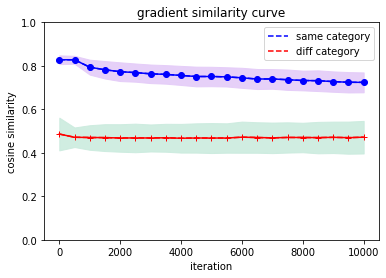

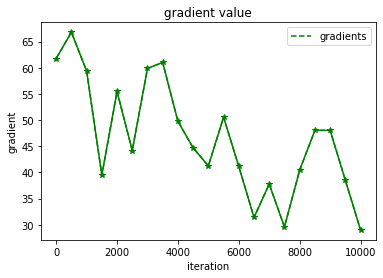

In [ ]:
x = np.arange(0, 10500, 500)
y1 = same_category_mean_s
y2 = dif_category_mean_s
y3 = gradients_s
s1 = same_variance_s
s2 = dif_variance_s
l1=plt.plot(x,y1,'b--',label='same category')
l2=plt.plot(x,y2,'r--',label='diff category')
plt.fill_between(x, np.array(y1) - np.array(s1), np.array(y1) + np.array(s1), color=(229/256, 204/256, 249/256), alpha=0.9)
plt.fill_between(x, np.array(y2) - np.array(s2), np.array(y2) + np.array(s2), color=(204/256, 236/256, 223/256), alpha=0.9)
plt.plot(x,y1,'bo-',x,y2,'r+-')
plt.ylim((0.0, 1.0))
plt.title('gradient similarity curve')
plt.xlabel('iteration')
plt.ylabel('cosine similarity')
plt.legend()
plt.show()

l3 = plt.plot(x,y3,'g--', label='gradients')
plt.plot(x, y3, 'g*-')
plt.title('gradient value')
plt.xlabel('iteration')
plt.ylabel('gradient')
plt.legend()
plt.show()

In [ ]:
print(gradients_s)

[-0.6904713]


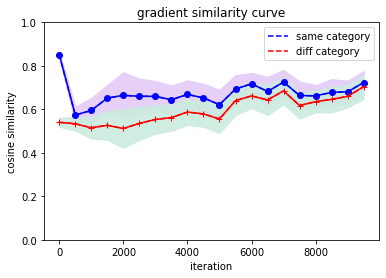

In [ ]:
x = np.arange(0, 10000, 500)
y1 = same_category_mean_w
y2 = dif_category_mean_w
s1 = same_variance_w
s2 = dif_variance_w
l1=plt.plot(x,y1,'b--',label='same category')
l2=plt.plot(x,y2,'r--',label='diff category')
plt.fill_between(x, np.array(y1) - np.array(s1), np.array(y1) + np.array(s1), color=(229/256, 204/256, 249/256), alpha=0.9)
plt.fill_between(x, np.array(y2) - np.array(s2), np.array(y2) + np.array(s2), color=(204/256, 236/256, 223/256), alpha=0.9)
plt.plot(x,y1,'bo-',x,y2,'r+-')
plt.ylim((0.0, 1.0))
plt.title('gradient similarity curve')
plt.xlabel('iteration')
plt.ylabel('cosine similarity')
plt.legend()
plt.show()

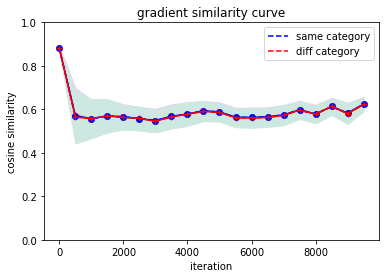

In [ ]:
x = np.arange(0, 10000, 500)
y1 = same_category_mean_o
y2 = dif_category_mean_o
s1 = same_variance_o
s2 = dif_variance_o
l1=plt.plot(x,y1,'b--',label='same category')
l2=plt.plot(x,y2,'r--',label='diff category')
plt.fill_between(x, np.array(y1) - np.array(s1), np.array(y1) + np.array(s1), color=(229/256, 204/256, 249/256), alpha=0.9)
plt.fill_between(x, np.array(y2) - np.array(s2), np.array(y2) + np.array(s2), color=(204/256, 236/256, 223/256), alpha=0.9)
plt.plot(x,y1,'bo-',x,y2,'r+-')
plt.ylim((0.0, 1.0))
plt.title('gradient similarity curve')
plt.xlabel('iteration')
plt.ylabel('cosine similarity')
plt.legend()
plt.show()

category:  0
0.5103722085216652 0.47815017419963457
0.4816339115172963 0.4562373946762238
0.7014678770905511 0.7665628507960579


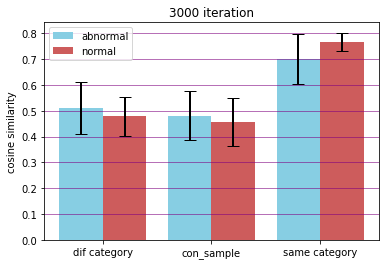

category:  1
0.4507408817273456 0.47100064895871846
0.3880995893548923 0.45969247713983274
0.6913168598211289 0.7675070090596399


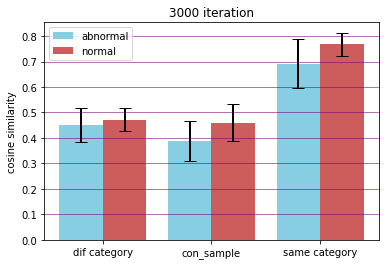

category:  2
0.49181655058345053 0.4619335397853179
0.48036339399674605 0.4209781718751404
0.7431987470596635 0.7557343519292692


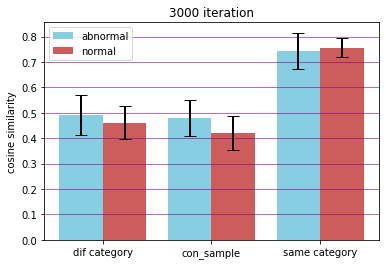

category:  3
0.49307411825961045 0.45615378727591493
0.5548419155733608 0.4598003876334372
0.7002353209968687 0.7255882180391482


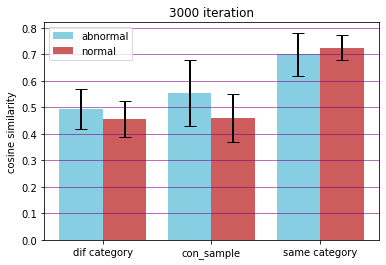

category:  4
0.5073900665088477 0.4332483906370157
0.48473049193950285 0.511627312381355
0.7426390213389276 0.7456215060733891


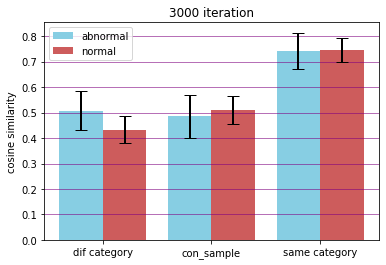

category:  5
0.43296069719224917 0.47530166495264015
0.52652638665508 0.4496138625730842
0.7590276163620772 0.7591840262349774


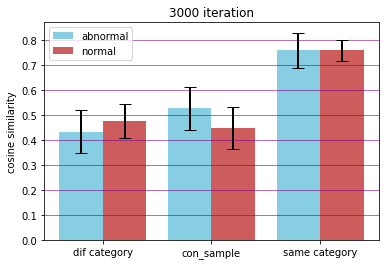

category:  6
0.46766906763204125 0.4271355363272602
0.521104747122216 0.48741205837987833
0.7446382814741844 0.7818458989465917


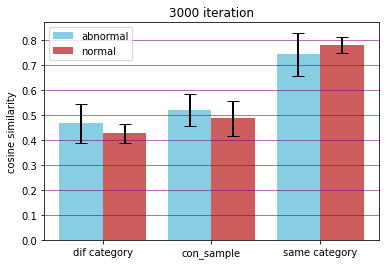

category:  7
0.4337044164410774 0.4295884028674614
0.5032556267953763 0.49873932330118453
0.7369297379483963 0.783858139990984


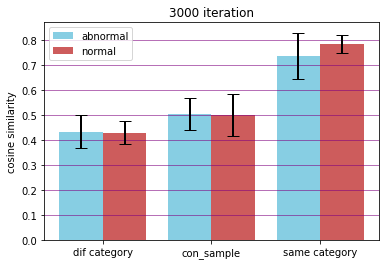

category:  8
0.501906541021606 0.4584199073551004
0.4706632802650287 0.44466506460625965
0.7178547014729622 0.7707580982188118


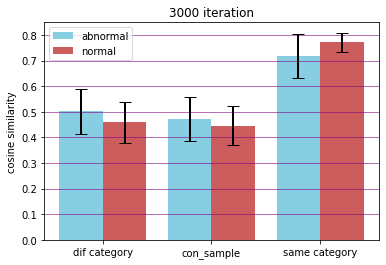

category:  9
0.4573625662089462 0.46960645858068173
0.4923504003009749 0.4913877766694555
0.7402031789150096 0.7505368008480127


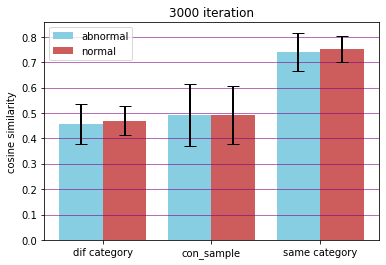

average gradient: 
category:  9
0.4746997114096839 0.45605385109397456
0.49035697435204745 0.46801538292358513
0.727751134247977 0.7607196900136882


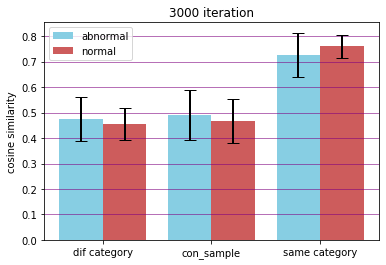

In [ ]:
plot_gradient(fshaww, slw, cpriv, 3000)

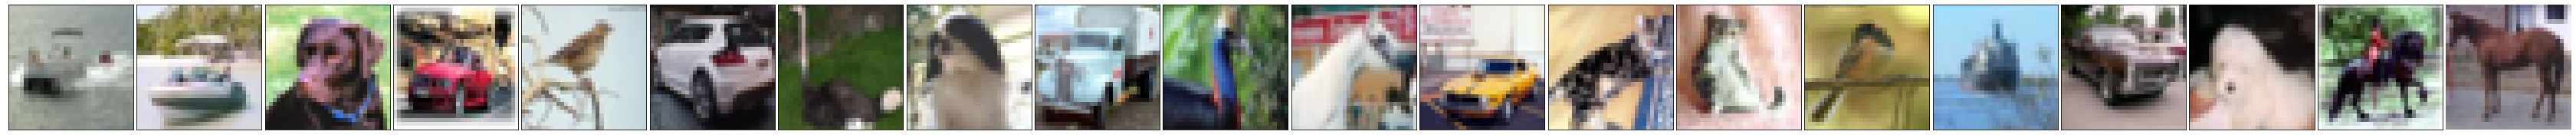

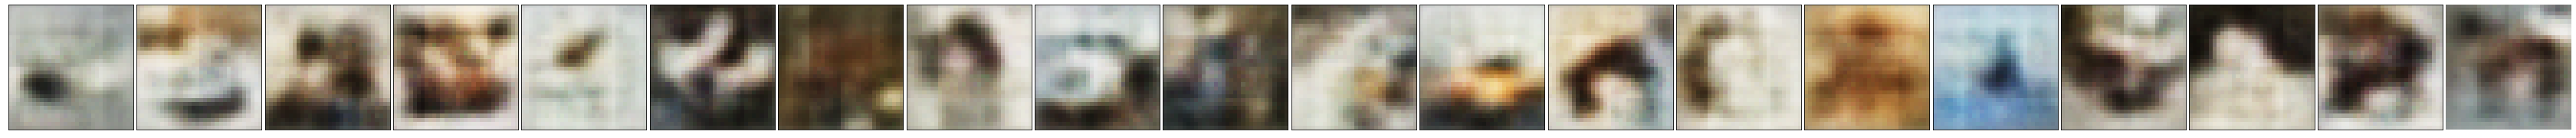

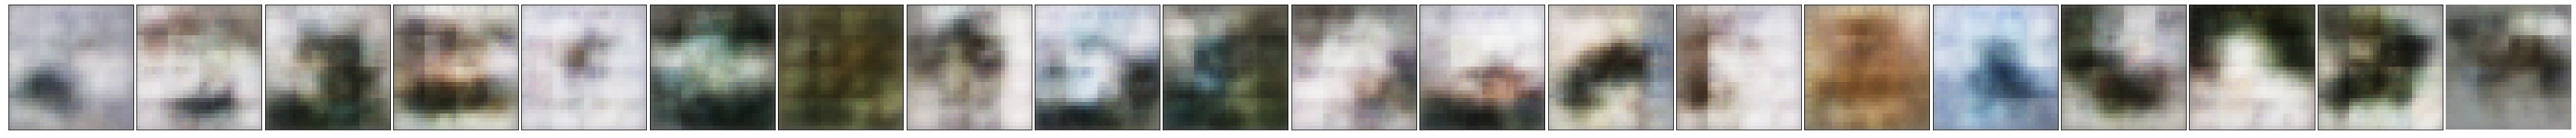

In [ ]:
n = 20
X = getImagesDS(cpriv, n)
X_recoveredo, control = fshao.attack(X)
X_recoveredw, control = fshaww.attack(X)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno');  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig


fig = plot(X)
fig = plot(X_recoveredo)
fig = plot(X_recoveredw)

[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
RUNNING...
log--00%-0000000] validation: 0.2884 , f_loss: 2.7963 , c_loss: 0.5659
log--10%-0001000] validation: 0.2494 , f_loss: 4.2745 , c_loss: 195.6233
log--20%-0002000] validation: 0.2319 , f_loss: 5.5232 , c_loss: 264.9328
log--30%-0003000] validation: 0.0945 , f_loss: 6.8666 , c_loss: 277.8904
log--40%-0004000] validation: 0.0699 , f_loss: 8.1488 , c_loss: 285.6078
log--50%-0005000] validation: 0.0642 , f_loss: 9.3888 , c_loss: 285.7816
log--60%-0006000] validation: 0.0624 , f_loss: 10.5523 , c_loss: 291.0574
log--70%-0007000] validation: 0.0617 , f_loss: 11.6047 , c_loss: 287.1135
log--80%-0008000] validation: 0.0628 , f_loss: 12.5152 , c_loss: 291.5387
log--90%-0009000] validation: 0.0631 , f_loss: 13.2525 , c_loss: 294.1976
[PILOT] activation:  None
[DECODER] activation:  None
RUNNING...
Use WGAN loss
Use GP
Use WGAN loss
Use GP
log--00%-0000000] validation: 0.2654
log--10%-0001000] validation: 0

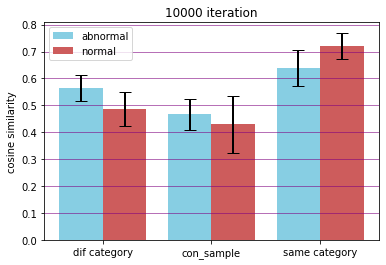

category:  1
0.5461021396705823 0.4670746769552639
0.45780754982592775 0.4930718195370811
0.6203164141716969 0.723923377420505


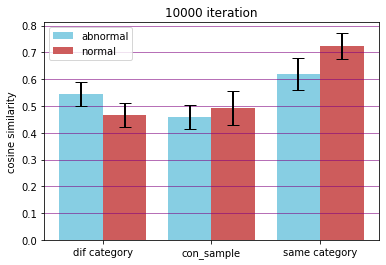

category:  2
0.545819344192102 0.4447842191822805
0.4807281702842634 0.4671359104148378
0.6255155827324829 0.7168059328623424


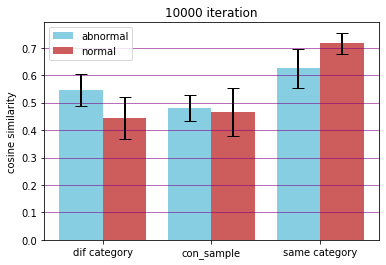

category:  3
0.5710584017224145 0.47895809223634056
0.4617713973732235 0.4117823321943832
0.6088841133286798 0.7090052175997417


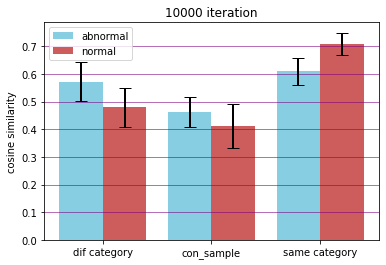

category:  4
0.5700937745431666 0.48442109728267857
0.48960232442390916 0.4855121934860161
0.6305813801451483 0.7254256382160161


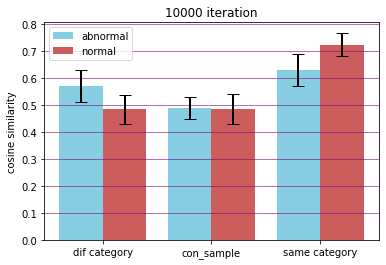

category:  5
0.5595490594387105 0.5050216405227625
0.47545916213568284 0.48879010935743106
0.6369256278477311 0.7137040525398117


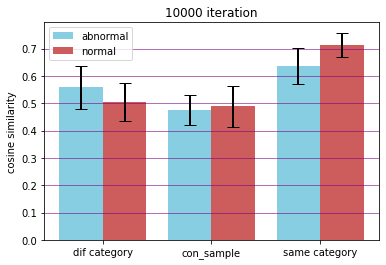

category:  6
0.5932256723854796 0.5001094588196328
0.4889296117002905 0.4778151786556625
0.652342412547166 0.7243046486922256


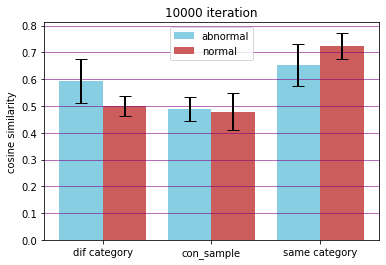

category:  7
0.5895053118137435 0.4811108357976868
0.5034091813307375 0.4738306899945847
0.6325680297968111 0.7285509355177001


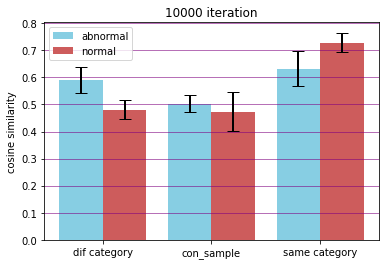

category:  8
0.5813926062415317 0.48949304013199224
0.47024661504529686 0.4441003539249115
0.6175917630408476 0.7185384555455321


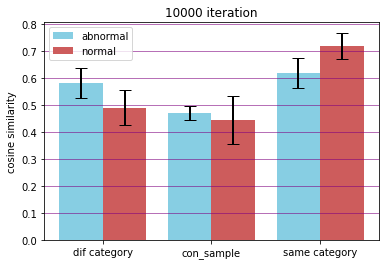

category:  9
0.5689084532168697 0.47812575500453686
0.49893208254232935 0.5011306486051905
0.6204331668448457 0.7155246825478361


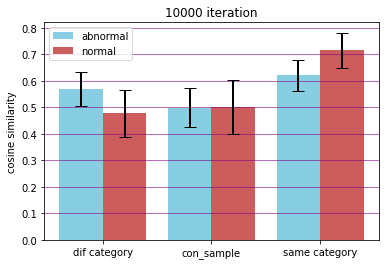

average gradient: 
category:  9
0.5691268506680806 0.4816320219180474
0.4793566469445417 0.4672618947602151
0.628422093442237 0.719693278341002


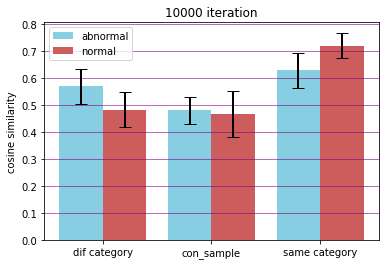

In [ ]:
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'w' : 10,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
}
fshaww = FSHA_worst(cpriv, cpub, id_setup-1, batch_size, hparams)
log_frequency = 1000
LOG = fshaww(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)
fshao = FSHA_ori(cpriv, cpub, id_setup-1, batch_size, hparams)
LOG = fshao(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)
slw = SL_new(cpriv, cpub, id_setup-1, batch_size, hparams)
LOG = slw(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)
plot_gradient(fshaww, slw, cpriv, 10000)

TypeError: ignored

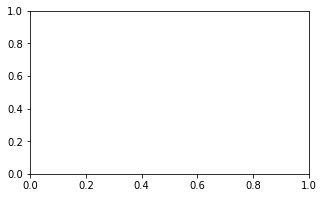

In [ ]:
def plot_log(ax, x, y, label):
    ax.plot(x, y, color='black')
    ax.set(title=label)
    ax.grid()

n = 1
fix, ax = plt.subplots(1, n, figsize=(n*5, 3))
x = np.arange(0, 10) * log_frequency
y = [0.2884, 0.2494, 0.2319, 0.0945, 0.0699, 0.0642, 0.0624, 0.0617, 0.0628,0.0631] 
y = np.array(y)

plot_log(ax[0], x, y, label='validation')
plt.savefig('loss.jpg')

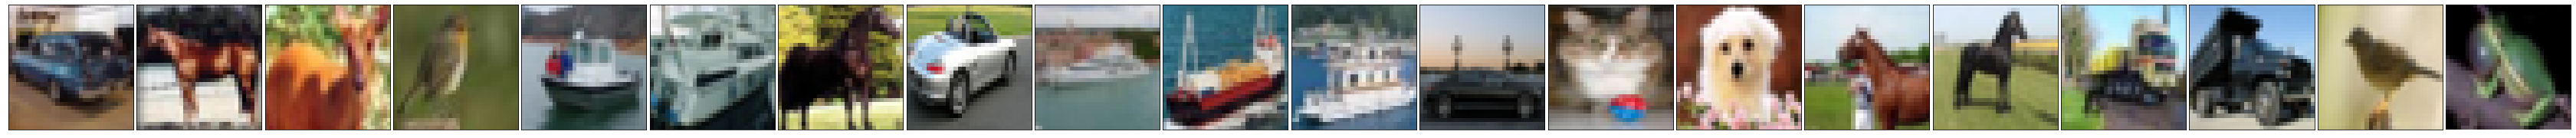

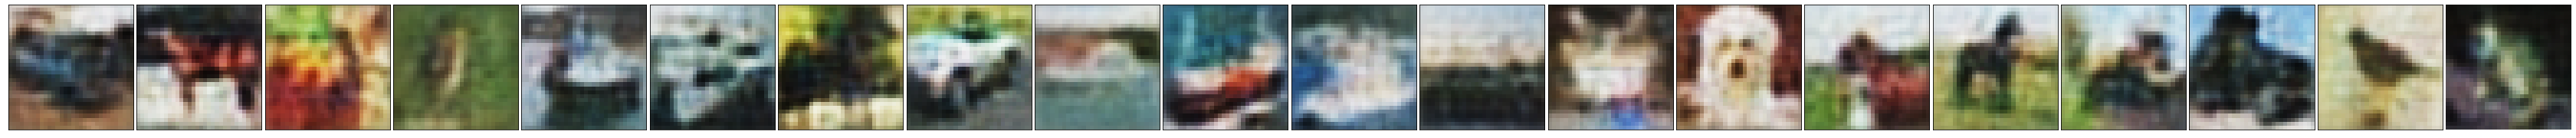

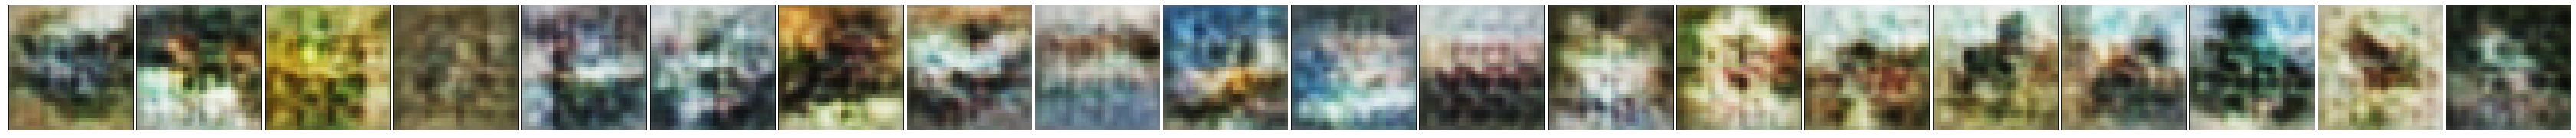

In [ ]:
n = 20
X = getImagesDS(cpriv, n)
X_recoveredo, control = fshao.attack(X)
X_recoveredw, control = fshaww.attack(X)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno');  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig


fig = plot(X)
fig = plot(X_recoveredo)
fig = plot(X_recoveredw)

category:  0
0.5140408364018386 0.49731343598772493
0.16794124711908998 0.43129618890265875
0.5012873603857287 0.7661554078568162


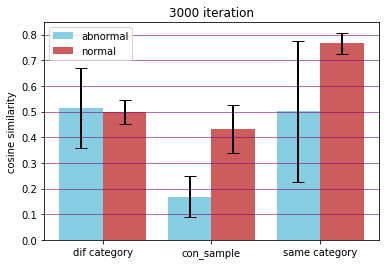

category:  1
0.5208653969945314 0.46020697242852737
0.14910899049316312 0.466271667312276
0.5324068306635918 0.7661221749213556


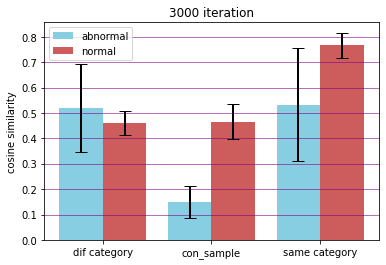

category:  2
0.5100922080578945 0.46070113766249693
0.12558718359895704 0.44053436383995104
0.5223812617037233 0.7598576614643959


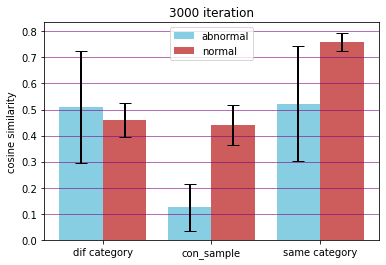

category:  3
0.5225847369959451 0.4651849544913007
0.10519318008945544 0.4717202329972833
0.48571084837334866 0.732894826580794


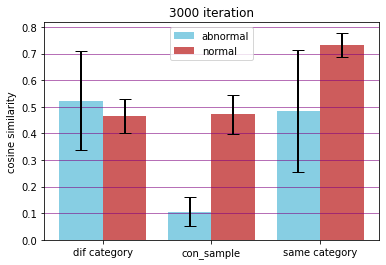

category:  4
0.5091078006394659 0.44214255523339735
0.22353303686713163 0.49290320739406446
0.5211408450522237 0.7488945636351266


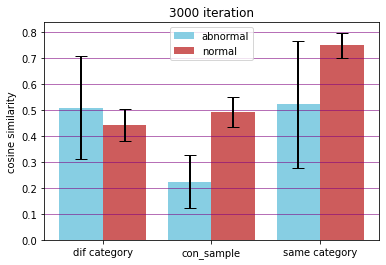

category:  5
0.5347871618099944 0.4865588082597201
0.10874617249431727 0.42686162390457266
0.5431751815183843 0.752512995261025


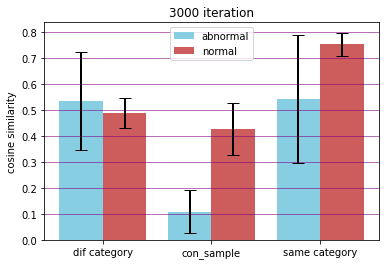

category:  6
0.5110656653938486 0.4364489747699254
0.11174006162242583 0.48132168946032916
0.547543849641737 0.7771524422070026


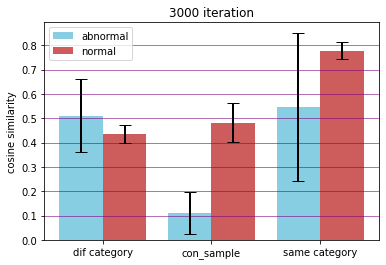

category:  7
0.49307371748023865 0.42659073197410496
0.11038192336864255 0.5017420259532777
0.563861431948858 0.7949859189073791


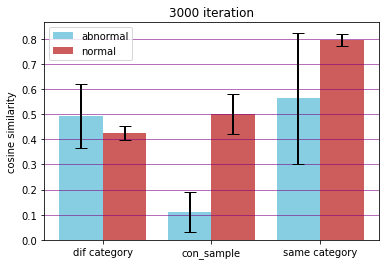

category:  8
0.5569437286325013 0.4426951209747741
0.20806854157009053 0.44119702336955724
0.5409246423988698 0.7673103461966556


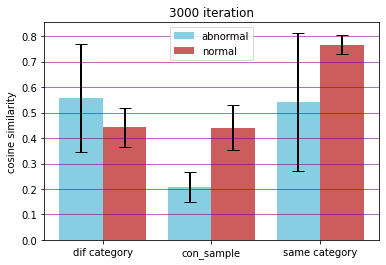

category:  9
0.49433462935787953 0.47874585626190097
0.21298109090054762 0.5086231331456654
0.5017280620210917 0.7547753146413672


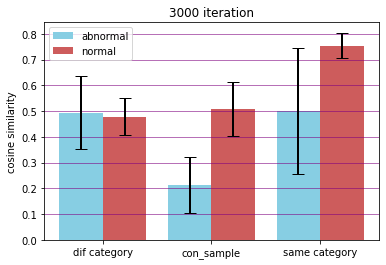

average gradient: 
category:  9
0.5166895881764137 0.45965885480438723
0.1523281428123821 0.46624711562796356
0.5260160313707557 0.7620661651671918


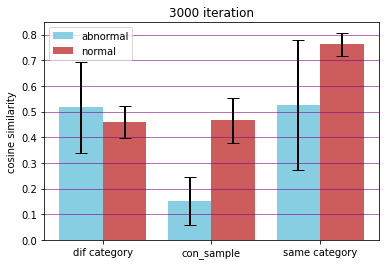

In [ ]:
plot_gradient(fshaww, slw, cpriv, 3000)

category:  0
0.49428045610643667 0.48688369176012986
0.11801679611715518 0.43762138948398066
0.5604277895516703 0.758469596984831


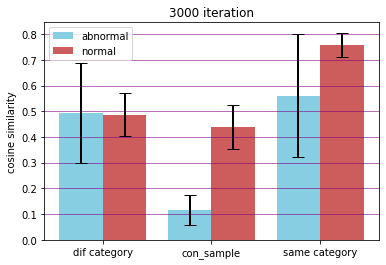

category:  1
0.5091114651184148 0.4847934529689194
0.12044068819899523 0.45272122018038274
0.5316361143754128 0.7742075614277459


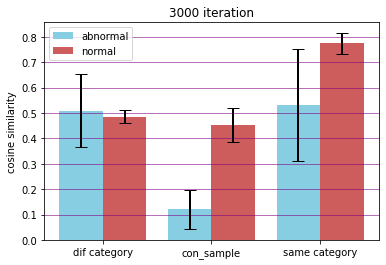

category:  2
0.5153844626186935 0.4389877515085393
0.14411609246848664 0.4701009246572442
0.5284383444911993 0.762953752015069


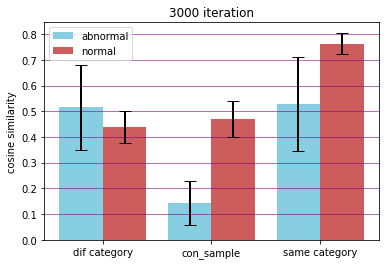

category:  3
0.47446872842584303 0.4661503306752039
0.07556456310482226 0.40193579811279734
0.5420437403215623 0.7428295345465681


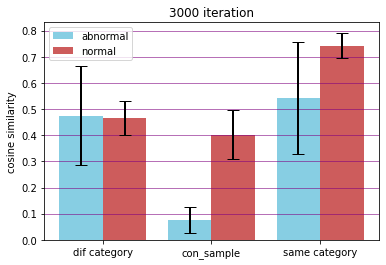

category:  4
0.47923122244153193 0.43984850832234634
0.1268633960145426 0.4893973668335142
0.5450619854630854 0.7634292953208084


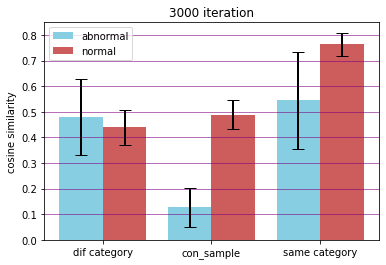

category:  5
0.5474922692267672 0.46642350055985543
0.07950573001927191 0.45853136580695786
0.4900652785147803 0.7653872451054013


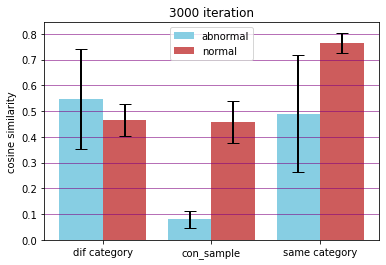

category:  6
0.491577631171983 0.4826699976629407
0.16960928012920323 0.49348099420636726
0.5172919064523117 0.7896159036176755


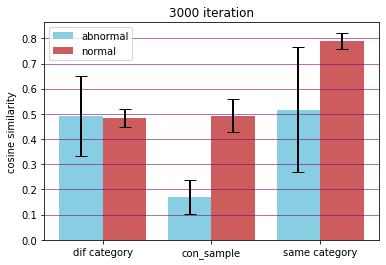

category:  7
0.48692770025619025 0.44847386520671434
0.07971436846525431 0.5022258586578903
0.5143195538487395 0.7896034401882432


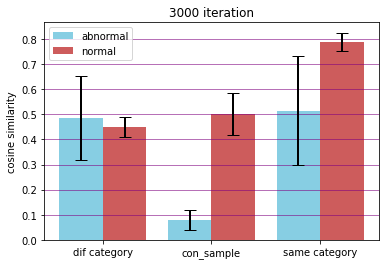

category:  8
0.5457840644496501 0.4774644182591987
0.1265554216093061 0.4582758152169647
0.5402075470704748 0.7793433537162495


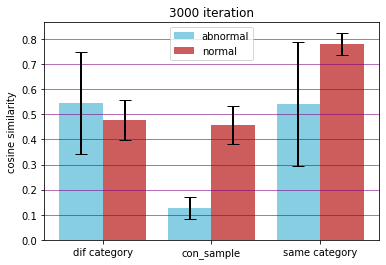

category:  9
0.5489185860259619 0.481059825785358
0.12262214212855795 0.5361952003483497
0.6469416009571638 0.7733529296782875


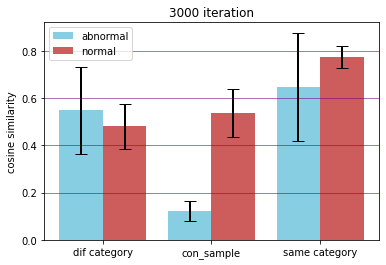

average gradient: 
category:  9
0.5093176585841472 0.46727553427092056
0.11630084782555954 0.4700485933504449
0.54164338610464 0.769919261260088


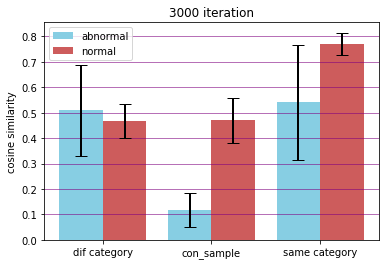

In [ ]:
plot_gradient(fshaww, slw, cpriv, 3000)

In [ ]:
fshaww = FSHA_worst(cpriv, cpub, id_setup-1, batch_size, hparams)
fshao = FSHA_ori(cpriv, cpub, id_setup-1, batch_size, hparams)
fshaw = FSHA_worse(cpriv, cpub, id_setup-1, batch_size, hparams)
log_frequency = 1000
LOG = fshaw(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)
LOG = fshao(8000, verbose=True, progress_bar=False, log_frequency=log_frequency)
LOG = fshaww(14000, verbose=True, progress_bar=False, log_frequency=log_frequency)
slw = SL_new(cpriv, cpub, id_setup-1, batch_size, hparams)
LOG = slw(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
[PILOT] activation:  None
[DECODER] activation:  None
[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
RUNNING...
log--00%-0000000] validation: 0.3040
log--10%-0001000] validation: 0.2644
log--20%-0002000] validation: 0.2597
log--30%-0003000] validation: 0.1072
log--40%-0004000] validation: 0.0699
log--50%-0005000] validation: 0.0662
log--60%-0006000] validation: 0.0656
log--70%-0007000] validation: 0.0638
log--80%-0008000] validation: 0.0641
log--90%-0009000] validation: 0.0645
RUNNING...
Use WGAN loss
Use GP
Use WGAN loss
Use GP
log--00%-0000000] validation: 0.2835
log--12%-0001000] validation: 0.1640
log--25%-0002000] validation: 0.0703
log--37%-0003000] validation: 0.0543
log--50%-0004000] validation: 0.0461
log--62%-0005000] validation: 0.0406
log--75%-0006000] validation: 0.0370
log--87%-0007000] validation: 0.0345
RUNNING...
(64, 128) <dtype: 'float32'>
(64, 128) <d

In [ ]:
n = 20
X = getImagesDS(cpriv, n)
X_recovered, control = fshao.attack(X)
X_recovered, control = fshaw.attack(X)
X_recovered, control = fshaww.attack(X)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno');  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig


fig = plot(X)
fig = plot(X_recovered)

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  0
0.5943344854242549 0.4740945795264847
0.37242318719450185 0.4175355547548626
0.6265667755676283 0.6959346292083588


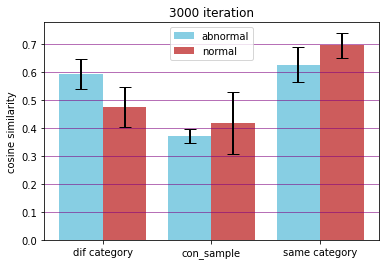

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  1
0.6124252987749448 0.4704912582876398
0.36821709985487566 0.46692005579599166
0.6114623581588718 0.7385031842930199


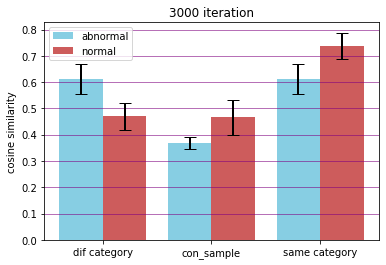

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  2
0.6180884112509635 0.4175766560128557
0.3717784155094387 0.4524169274074019
0.6219204011372933 0.7267652825784949


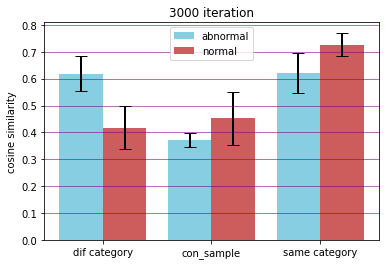

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  3
0.5953794754484929 0.4741712695688495
0.3674963921270321 0.4631548200931779
0.6077666426012902 0.7012994676075983


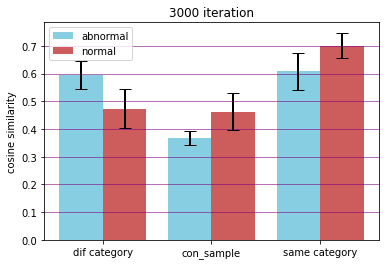

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  4
0.6060782196891654 0.46173530533298973
0.3839411524214572 0.5078400630249169
0.6292101266055501 0.7200877012744396


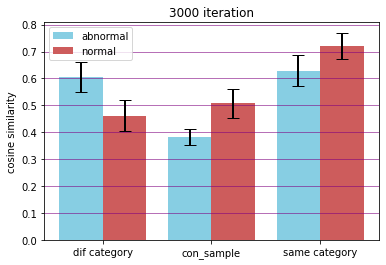

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  5
0.5946080567343522 0.5057555373255158
0.3635971908400264 0.4837552878512887
0.6076923267572425 0.7132563764294901


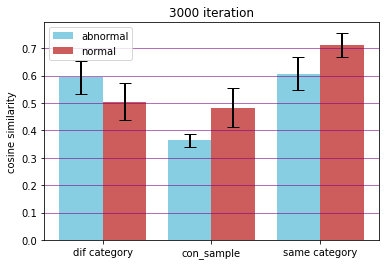

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  6
0.6203438074417382 0.47768344277768726
0.3830698617281376 0.4746176177995095
0.6316936238026837 0.7129472512478726


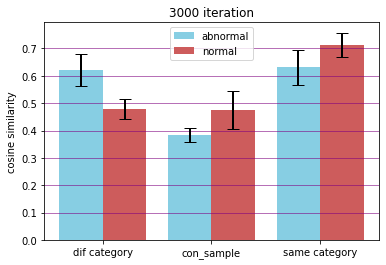

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  7
0.5827210889376302 0.46814719261232507
0.36740307040555764 0.5165979247338406
0.6184326190376965 0.723099273740933


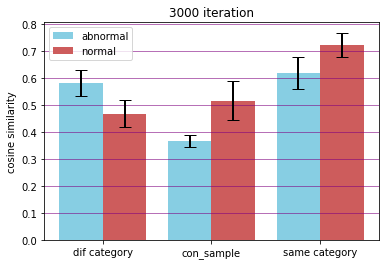

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  8
0.5998097438044165 0.47425677877259903
0.3730313432393878 0.4150970686022998
0.6328279906262426 0.7341780744027002


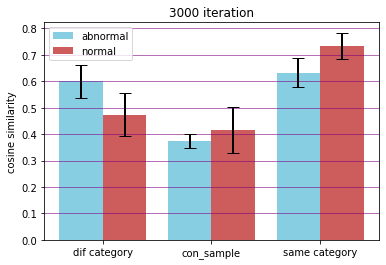

(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
(64, 128) <dtype: 'float32'>
category:  9
0.6176837066139169 0.463816763415702
0.36776248669441164 0.4614582462537554
0.6275262863428079 0.7105355325035962


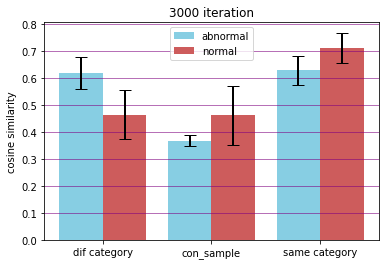

In [ ]:
plot_gradient(fshaw, slw, cpriv)

In [ ]:
def projection_layer(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Flatten()(xin)
    x = tf.keras.layers.Dense(128)(x)
    return tf.keras.Model(xin, x)

# UTT attack model
import tqdm
import datasets, architectures, arch
# import tensorflow.compat.v1 as tf
# tf.enable_eager_execution()

def distance_data_loss(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

def distance_data(a,b):
    l = tf.losses.MeanSquaredError()
    return l(a, b)

class FSHA_worst_CL:
    
    def loadBiasNetwork(self, make_decoder, z_shape, channels):
        return make_decoder(z_shape, channels=channels)
        
    def __init__(self, xpriv, xpub, id_setup, batch_size, hparams):
            input_shape = xpriv.element_spec[0].shape
            # print("input shape: ", input_shape)
            self.hparams = hparams

            # setup dataset
            self.client_dataset = xpriv.batch(batch_size, drop_remainder=True).repeat(-1)
            self.attacker_dataset = xpub.batch(batch_size, drop_remainder=True).repeat(-1)
            self.batch_size = batch_size

            ## setup models
            make_f, make_tilde_f, make_decoder, make_D = architectures.SETUPS[id_setup]
            _, make_S = arch.SETUPS[id_setup]
            _, classifier = arch.SETUPS[id_setup]

            self.f = make_f(input_shape)
            self.tilde_f = make_tilde_f(input_shape)

            assert self.f.output.shape.as_list()[1:] == self.tilde_f.output.shape.as_list()[1:]
            z_shape = self.tilde_f.output.shape.as_list()[1:]
            print("feature shape: ", z_shape)
            self.P = projection_layer(z_shape)
            self.D = make_D(z_shape)
            self.decoder = self.loadBiasNetwork(make_decoder, z_shape, channels=input_shape[-1])
            self.S = make_S(z_shape)
            self.c = classifier(z_shape)
            # print("output shape: ", self.S.output.shape.as_list()[1:])

            self.w = hparams['w']

            # setup optimizers
            self.optimizer0 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_f'])
            self.optimizer1 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_tilde'])
            self.optimizer2 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_D'])
            self.optimizer3 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_D'])
            self.optimizer4 = tf.keras.optimizers.Adam(learning_rate=hparams['lr_tilde'])

            # gradient
            self.gradient = ''



    @staticmethod
    def addNoise(x, alpha):
        return x + tf.random.normal(x.shape) * alpha

    @tf.function
    def train_step(self, x_private, x_public, label_private, label_public):

        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=True)
            ####################################


            #### SERVER-SIDE:
            # map to data space (for evaluation and style loss)
            rec_x_private = self.decoder(z_private, training=True)
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=True)
            z = self.P(z_private, training = True)
            # print(z.shape, z.dtype)
            f_loss_1 = losses.max_margin_contrastive_loss(z, label_private, metric='cosine')


            if self.hparams['WGAN']:
                # print("Use WGAN loss")
                f_loss = tf.reduce_mean(adv_private_logits) + self.w*f_loss_1
            else:
                f_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True)) + f_loss_1
            ##

            z_public = self.tilde_f(x_public, training=True)
            public_logits = self.c(z_public, training=True)
            c_loss = tf.keras.losses.sparse_categorical_crossentropy(label_public, public_logits, from_logits=True)

            # invertibility loss
            rec_x_public = self.decoder(z_public, training=True)
            public_rec_loss = distance_data_loss(x_public, rec_x_public)
            tilde_f_loss = public_rec_loss


            # discriminator on attacker's feature-space
            adv_public_logits = self.D(z_public, training=True)
            if self.hparams['WGAN']:
                loss_discr_true = tf.reduce_mean( adv_public_logits )
                loss_discr_fake = -tf.reduce_mean( adv_private_logits)
                # discriminator's loss
                D_loss = loss_discr_true + loss_discr_fake
            else:
                loss_discr_true = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_public_logits), adv_public_logits, from_logits=True))
                loss_discr_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(adv_private_logits), adv_private_logits, from_logits=True))
                # discriminator's loss
                D_loss = (loss_discr_true + loss_discr_fake) / 2

            if 'gradient_penalty' in self.hparams:
                # print("Use GP")
                w = float(self.hparams['gradient_penalty'])
                D_gradient_penalty = self.gradient_penalty(z_private, z_public)
                D_loss += D_gradient_penalty * w

            ##################################################################
            ## attack validation #####################
            loss_c_verification = distance_data(x_private, rec_x_private)
            ############################################
            ##################################################################

            #### SUB-SERVER-SIDE:
            ## loss (f's output must similar be to \tilde{f}'s output):
            private_logits = self.S(z_private, training=True)
            sf_loss = tf.keras.losses.sparse_categorical_crossentropy(label_private, private_logits, from_logits=True)
            ##

        # train supervised autoencoder
        var = self.tilde_f.trainable_variables + self.c.trainable_variables
        gradients = tape.gradient(c_loss, var)
        self.optimizer4.apply_gradients(zip(gradients, var))

        # train substitute network 
        var = self.S.trainable_variables
        gradients = tape.gradient(sf_loss, var)
        self.optimizer3.apply_gradients(zip(gradients, var))


        # train client's network 
        var = self.f.trainable_variables + self.P.trainable_variables
        gradients = tape.gradient(f_loss, var)
        self.optimizer0.apply_gradients(zip(gradients, var))
        

        # train attacker's autoencoder(decoder part) on public data
        var = self.decoder.trainable_variables
        gradients = tape.gradient(tilde_f_loss, var)
        self.optimizer1.apply_gradients(zip(gradients, var))

        # train discriminator
        var = self.D.trainable_variables
        gradients = tape.gradient(D_loss, var)
        self.optimizer2.apply_gradients(zip(gradients, var))


        return f_loss, tilde_f_loss, D_loss, loss_c_verification

    def get_gradient(self, x_private, label_private):
        with tf.GradientTape(persistent=True) as tape:

            #### Virtually, ON THE CLIENT SIDE:
            # clients' smashed data
            z_private = self.f(x_private, training=False)
            ####################################


            #### SERVER-SIDE:
            ## adversarial loss (f's output must similar be to \tilde{f}'s output):
            adv_private_logits = self.D(z_private, training=False)
            z = self.P(z_private, training = False)
            # print(z.shape, z.dtype)
            f_loss_1 = losses.max_margin_contrastive_loss(z, label_private, metric='cosine')
            if self.hparams['WGAN']:
                # print("Use WGAN loss")
                f_loss = tf.reduce_mean(adv_private_logits) + self.w*f_loss_1
            else:
                f_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(adv_private_logits), adv_private_logits, from_logits=True)) + f_loss_1
            ##

        var = z_private
        gradients = tape.gradient(f_loss, var)
        return gradients


    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.D(x_hat, training=True)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer
    
    
    @tf.function
    def score(self, x_private, label_private):
        z_private = self.f(x_private, training=False)
        tilde_x_private = self.decoder(z_private, training=False)
        
        err = tf.reduce_mean( distance_data(x_private, tilde_x_private))
        
        return err
    
    def scoreAttack(self, dataset):
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        scorelog = 0
        i = 0
        for x_private, label_private in tqdm.tqdm(dataset):
            scorelog += self.score(x_private, label_private).numpy()
            i += 1
             
        return scorelog / i

    def attack(self, x_private):
        # smashed data sent from the client:
        z_private = self.f(x_private, training=False)
        # recover private data from smashed data
        tilde_x_private = self.decoder(z_private, training=False)

        z_private_control = self.tilde_f(x_private, training=False)
        control = self.decoder(z_private_control, training=False)
        return tilde_x_private.numpy(), control.numpy()


    def __call__(self, iterations, log_frequency=500, verbose=False, progress_bar=True):

        n = int(iterations / log_frequency)
        LOG = np.zeros((n, 4))
        dif_category = []
        same_category = []
        for i in range(10):
          dif_category.append([])
          same_category.append([])
        dif_category_mean = []
        same_category_mean = []
        dif_variance = []
        same_variance = []
        gradients = []
        dif_category_mean_ = []
        same_category_mean_ = []

        iterator = zip(self.client_dataset.take(iterations), self.attacker_dataset.take(iterations))
        if progress_bar:
            iterator = tqdm.tqdm(iterator , total=iterations)
        for k in range(10):
          gp1 = self.get_gradient(c1x[k], c1y[k]).numpy()
          gp2 = self.get_gradient(c2x[k], c2y[k]).numpy()
          gp3 = self.get_gradient(c3x[k], c3y[k]).numpy()

          dif_category_fsha = []
          same_category_fsha = []
          gradient_ = []
          
          for l in range(64):
            p1 = gp1[l].reshape(4096,)
            p2 = gp2[l].reshape(4096,)
            p3 = gp3[l].reshape(4096,)
            gradient_.append(np.sum(np.abs(p1)))
            dif_category_fsha.append(get_cos_sim(p1,p2))
            same_category_fsha.append(get_cos_sim(p1,p3))
            dif_category_mean_.append(get_cos_sim(p1,p2))
            same_category_mean_.append(get_cos_sim(p1,p3))
          dif_category_fsha = np.array(dif_category_fsha)
          same_category_fsha = np.array(same_category_fsha)
          gradient_ = np.array(gradient_)
          dif_category[k].append(np.mean(dif_category_fsha))
          same_category[k].append(np.mean(dif_category_fsha))
        dif_category_mean_ = np.array(dif_category_mean_)
        same_category_mean_ = np.array(same_category_mean_)
        dif_category_mean.append(np.mean(dif_category_mean_))
        same_category_mean.append(np.mean(same_category_mean_))
        gradients.append(np.mean(gradient_))
        dif_variance.append(np.std(dif_category_mean_))
        same_variance.append(np.std(same_category_mean_))

        i, j = 0, 0
        print("RUNNING...")
        public_data = []
        for datalist in cpub10:
          # print(len(list(datalist)))
          public_data.append(list(datalist))

        # print(len(public_data))
        for (x_private, label_private), (_, _) in iterator:
            # public_data = random.shuffle(public_data)
            for index,l in enumerate(label_private):
              category = l.numpy()[0]
              # print(category)
              if index == 0:
                random.shuffle(public_data[category])
                # print(len(public_data[category]))
                x_public = tf.reshape(public_data[category][0][0], [1,32,32,3])
              else:
                random.shuffle(public_data[category])
                x_public = tf.concat([x_public, tf.reshape(public_data[category][0][0], [1,32,32,3])], axis=0)
              
            log = self.train_step(x_private, x_public, label_private, label_private)

            if i == 0:
                VAL = log[3]                           
            else:
                VAL += log[3] / log_frequency

            if  i % log_frequency == 0:
                LOG[j] = log
                dif_category_mean_ = []
                same_category_mean_ = []
                for k in range(10):
                  gp1 = self.get_gradient(c1x[k], c1y[k]).numpy()
                  gp2 = self.get_gradient(c2x[k], c2y[k]).numpy()
                  gp3 = self.get_gradient(c3x[k], c3y[k]).numpy()

                  dif_category_fsha = []
                  same_category_fsha = []
                  gradient_ = []
                  
                  for l in range(64):
                    p1 = gp1[l].reshape(4096,)
                    p2 = gp2[l].reshape(4096,)
                    p3 = gp3[l].reshape(4096,)
                    gradient_.append(np.sum(np.abs(p1)))
                    dif_category_fsha.append(get_cos_sim(p1,p2))
                    same_category_fsha.append(get_cos_sim(p1,p3))
                    dif_category_mean_.append(get_cos_sim(p1,p2))
                    same_category_mean_.append(get_cos_sim(p1,p3))
                  dif_category_fsha = np.array(dif_category_fsha)
                  same_category_fsha = np.array(same_category_fsha)
                  dif_category[k].append(np.mean(dif_category_fsha))
                  same_category[k].append(np.mean(dif_category_fsha))
                  gradient_ = np.array(gradient_)
                dif_category_mean_ = np.array(dif_category_mean_)
                same_category_mean_ = np.array(same_category_mean_)
                dif_category_mean.append(np.mean(dif_category_mean_))
                same_category_mean.append(np.mean(same_category_mean_))
                gradients.append(np.mean(gradient_))
                dif_variance.append(np.std(dif_category_mean_))
                same_variance.append(np.std(same_category_mean_))

                if verbose:
                    print("log--%02d%%-%07d] validation: %0.4f" % ( int(i/iterations*100) ,i, VAL))
                    # self.gradient = self.get_gradient(x_private, label_private)

                VAL = 0
                j += 1


            i += 1
        return LOG, dif_category, same_category, dif_category_mean, same_category_mean, dif_variance, same_variance, gradients

In [ ]:
fshaww = FSHA_worst_CL(cpriv, cpub, id_setup-1, batch_size, hparams)
LOGw, dif_category_w, same_category_w, dif_category_mean_w, same_category_mean_w, dif_variance_w, same_variance_w, gradients_w = fshaww(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

[PILOT] activation:  None
feature shape:  [4, 4, 256]
[DECODER] activation:  None
RUNNING...
log--00%-0000000] validation: 0.2678
log--01%-0000100] validation: 0.2683
log--02%-0000200] validation: 0.2563
log--03%-0000300] validation: 0.2544
log--04%-0000400] validation: 0.2532
log--05%-0000500] validation: 0.2474
log--06%-0000600] validation: 0.2510
log--07%-0000700] validation: 0.2600
log--08%-0000800] validation: 0.2667
log--09%-0000900] validation: 0.2734
log--10%-0001000] validation: 0.2801
log--11%-0001100] validation: 0.2884
log--12%-0001200] validation: 0.2944
log--13%-0001300] validation: 0.2920
log--14%-0001400] validation: 0.2990
log--15%-0001500] validation: 0.2976
log--16%-0001600] validation: 0.3033
log--17%-0001700] validation: 0.3025
log--18%-0001800] validation: 0.2980
log--19%-0001900] validation: 0.2980
log--20%-0002000] validation: 0.2946
log--21%-0002100] validation: 0.2918
log--22%-0002200] validation: 0.2887
log--23%-0002300] validation: 0.2856
log--24%-0002400] v

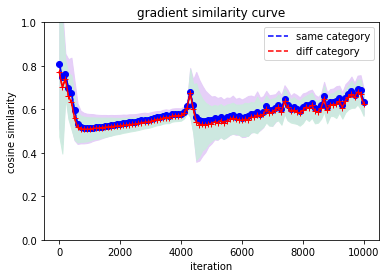

In [ ]:
x = np.arange(0, 10100, 100)
y1 = same_category_mean_w
y2 = dif_category_mean_w
s1 = same_variance_w
s2 = dif_variance_w
l1=plt.plot(x,y1,'b--',label='same category')
l2=plt.plot(x,y2,'r--',label='diff category')
plt.fill_between(x, np.array(y1) - np.array(s1), np.array(y1) + np.array(s1), color=(229/256, 204/256, 249/256), alpha=0.9)
plt.fill_between(x, np.array(y2) - np.array(s2), np.array(y2) + np.array(s2), color=(204/256, 236/256, 223/256), alpha=0.9)
plt.plot(x,y1,'bo-',x,y2,'r+-')
plt.ylim((0.0, 1.0))
plt.title('gradient similarity curve')
plt.xlabel('iteration')
plt.ylabel('cosine similarity')
plt.legend()
plt.show()